## Regolarizzazione di Tikhonov

E' quindi necessario applicare una regolarizzazione. Iniziamo considerando la funzione di regolarizzazione di Tikhonov:

$$min_x f(x)= min_x||Ax-y^{\delta}||_2^2 + \lambda ||x||_2^2$$

dove $\lambda$ è il parametro di regolarizzazione.

Applicando le condizioni del primo ordine $\nabla(f)=0$  alla precdente funzione (convessa), si ottiene:

$$(A^TA+ \lambda I)x=A^Ty^{\delta}$$

Questo sistema lineare ha matrice ancora simmetrica e definita positivia quindi posso risolverlo applicando il metodo CGLS.

In [1]:
# CRAZIONE di un PROBLEMA TEST

from ProblemiInversi import operators, solvers, utilities
import numpy as np
import matplotlib.pyplot as plt

from skimage import data

# Lettura dei dati da skimage
x = data.camera()

# Lettura dati da file immagine
#x=plt.imread("Baboon.bmp")

nx, ny = x.shape

# Normalizzazione (nel range [0, 1])
x = x / x.max()


# Definizione kernel di blur e operatore associato
kernel = utilities.gaussian2d_kernel(k=11, sigma=3.5)
A = operators.ConvolutionOperator(kernel)

# Sfocatura dell'immagine e aggiunta di rumore
y = A(x)
y_delta = y + utilities.gaussian_noise(y, noise_level=0.05)


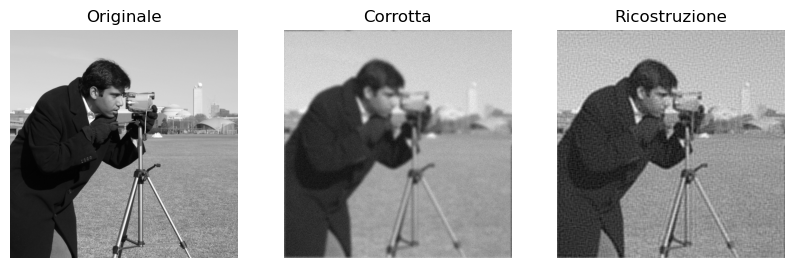

ER 0.1112382779837687
PSNR 23.765681657974124
SSIM 0.4197453088038706


In [2]:
# Calcolo soluzione regolarizzata con il metodo di Tikhonov e lambda fissato
# Problema di minimo risolto con CGLS

# Scelta parametri Tikhonov (L e lambda)
L = operators.Identity()
lmbda = 0.1

# Costruzione operatore di Tikhonov
M = operators.TikhonovOperator(A, L, lmbda)

# Definizione dati estesi ybar e ybar_delta
ybar = np.pad(y, ((0, 512), (0, 0)))
ybar_delta = np.pad(y_delta, ((0, 512), (0, 0)))

# Solver CGLS + Tikhonov
cgls_tik_solver = solvers.CGLS(M)

# Scelta di x0, kmax, tolf, tolx
x0 = np.zeros_like(x)
kmax = 100
tolf = 1e-8
tolx = 1e-8

# Soluzione
x_tik = cgls_tik_solver.solve(ybar_delta, x0, kmax, tolf, tolx)

# Visualizzazione ricostruzione
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(x, cmap="gray")
plt.title("Originale")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(y_delta, cmap="gray")
plt.axis("off")
plt.title("Corrotta")

plt.subplot(1, 3, 3)
plt.imshow(x_tik, cmap="gray")
plt.axis("off")
plt.title("Ricostruzione")
plt.show()

#Calcolo metriche di errore
print('ER',utilities.rel_err(x_tik,x))
print('PSNR',utilities.psnr(x_tik,x))
print('SSIM',utilities.ssim(x_tik,x))

iterazioni 101


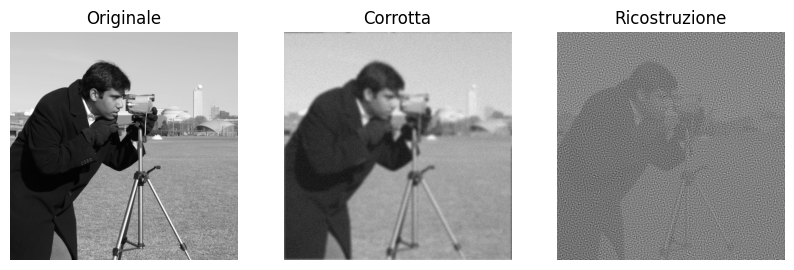

ER 1.7192749244769738
PSNR -0.016139779723850577
SSIM 0.07330448578293339


In [5]:
lmbda = 0.001

# Costruzione operatore di Tikhonov
M = operators.TikhonovOperator(A, L, lmbda)

# Solver CGLS + Tikhonov
cgls_tik_solver = solvers.CGLS(M)


# Soluzione
x_tik = cgls_tik_solver.solve(ybar_delta, x0, kmax, tolf, tolx)

# Visualizzazione ricostruzione
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(x, cmap="gray")
plt.title("Originale")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(y_delta, cmap="gray")
plt.axis("off")
plt.title("Corrotta")

plt.subplot(1, 3, 3)
plt.imshow(x_tik, cmap="gray")
plt.axis("off")
plt.title("Ricostruzione")
plt.show()

#Calcolo metrice di errore
print('ER',utilities.rel_err(x_tik,x))
print('PSNR',utilities.psnr(x_tik,x))
print('SSIM',utilities.ssim(x_tik,x))

iterazioni 13


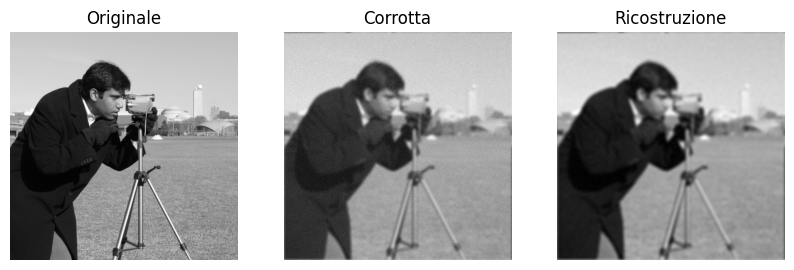

ER 0.511395698577866
PSNR 10.515625385704443
SSIM 0.6703658226529469


In [6]:
lmbda = 1

# Costruzione operatore di Tikhonov
M = operators.TikhonovOperator(A, L, lmbda)

# Solver CGLS + Tikhonov
cgls_tik_solver = solvers.CGLS(M)

# Soluzione
x_tik = cgls_tik_solver.solve(ybar_delta, x0, kmax, tolf, tolx)

# Visualizzazione ricostruzione
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(x, cmap="gray")
plt.title("Originale")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(y_delta, cmap="gray")
plt.axis("off")
plt.title("Corrotta")

plt.subplot(1, 3, 3)
plt.imshow(x_tik, cmap="gray")
plt.axis("off")
plt.title("Ricostruzione")
plt.show()

#Calcolo metrice di errore
print('ER',utilities.rel_err(x_tik,x))
print('PSNR',utilities.psnr(x_tik,x))
print('SSIM',utilities.ssim(x_tik,x))

**Come scegliere il parametro di regolarizzazione nel metodo di Tikhonov?**

La scelta del parametro di regolarizzazione  e' sicuramente la parte piu' delicata della regolarizzazione. Come abbiamo visto dal nostro test, un parametro troppo piccolo non toglie il rumore dalla soluzione, mentre un parametro troppo grande produce una soluzione troppo regolare, in cui non e' piu' presente il rumore ma per esempio le oscillazioni o i picchi che ci sono nella soluzione esatta vengono troppo ridotti.

Teoricamente il valore ottimale del parametro $\lambda_{opt}$ e' quello che minimizza:

$$\lambda_{opt}=min_{\lambda}||x_{\lambda}-x_{GT}||_2^2$$

dove $x_{\lambda}$ e' la soluzione calcolata in corrispondenza di un certo $\lambda$ e $x_{GT}$ e' la soluzione esatta (o ***ground truth***). 

Non esiste un metodo sempre efficiente per scegliere il parametro di regolarizzazione. Sicuramente in pratica spesso si usa una tecnica euristica che consiste nel provare alcuni parametri e scegliere quello che produce la soluzione che ci sembra migliore (trial and test).

Ci sono poi tecniche proposte che spesso non sono computazionalmente efficienti  perche' richiedono molte  esecuzioni del problema con parametri differenti per sceglierne poi uno sulla base di una certa regola.

La tecnica sicuramente piu' utilizzata in pratica e 'il principio di massima discrepanza.


***Principio di maassima discrepanza***

Supponendo di avere informazioni sul rumore, in particolare di conoscere la norma del rumore $||\delta||_2$ possiamo applicare il ***principio di massima discrepanza***.

***Principio di massima discrepanza***

Il parametro $\lambda_{DP}$ scelto con il principio di Massima Discrepanza, o Discrepancy Principle (DP), deve soddisfare la seguente relazione:

$$||Ax_{tik}-y^{\delta}\|_2^2=\nu_{DP}||\delta||_2^2$$

Poiche il residuo varia con continuita' e in modo monotono la soluzione alla precedente formula esiste ed e' unica.
La definizione ci dice che la norma del residuo deve essere uguale alla discrepanza sui dati, $\nu_{DP}||\delta||_2^2$.

Il parametro $\nu_{DP}$ viene scelto di solito come un valore di poco superiore a uno (per esempio 1.01 oppure 1.001).

**NB** Notiamo che il DP richiede la conoscenza della norma del rumore $||\delta||$, (o almeno una stima di esso),
che in generale non e' necessariamente nota in pratica.

**NB** Ovviamente calcolare $$||Ax_{tik}-y^{\delta}\|_2^2=\nu_{DP}||\delta||_2^2$$ o $$||Ax_{tik}-y^{\delta}\|_2=\nu_{DP}||\delta||_2$$ è equivalente ma si preferisce utilizzare la forma con i quadrati per semplificare il calcolo delle derivate prime. Nonostante ciò è ovvio che i risultati trovati sono analoghi.

Il parametro di regolarizzazione può essere scelto quindi utilizzando il criterio di Massima Discrepanza oppure un  criterio euristico. 
Per verificare sperimentalmente il parametro "ottimale" nel caso in cui si abbia la soluzione esatta (cioè in un problema test) è quello di verificare quale parametro rispetto a quelli scelti produce l' errore minore rispetto alla "ground truth" $x_{GT}$, utilizzando per esempio l' errore relativo già definito in precdenza:

$$ER=\frac{||x-x_{GT}||_2^2}{||x_{GT}||_2^2}$$


## Regolarizzazione con Variazione Totale

Una funzione di regolarizzazione alternativa a quella di Tikhonov e molto utilizzata nell'imaging è la funzione di Variazione Totale (TV) definita in questo modo:

$$TV(x)=||\nabla(x)||_1=\sum_{i=1}^M\sum_{j=1}^n \sqrt{(x_{i+1,j}-x_{i,j})^2+(x_{i,j+1}-x_{i,j})^2}$$

La funzione TV non è differenziabile nel punto (0,0). Per ottenre la differenziabilità, si inserice un piccolo parametro $\beta>0$:

$$TV^{\beta}(x)=\sum_{i=1}^m\sum_{j=1}^n \sqrt{(x_{i+1,j}-x_{i,j})^2+(x_{i,j+1}-x_{i,j})^2+\beta^2}$$

valori di solito utilizzati per $\beta$ sono dell' ordine di $10^{-3}$.

Il problema di regolarizzazione diventa quindi:

$$min_x ||Ax-y^{\delta}||_2^2+\lambda TV^{\beta}(x)$$


Questo problema di minimo di una funzione convessa puo essere risolto per esempio con il metodo di discesa del gradiente, utilizzando l'algoritmo di backtracking per la scelta del passo per garantirne la convergenza al punto di minimo.

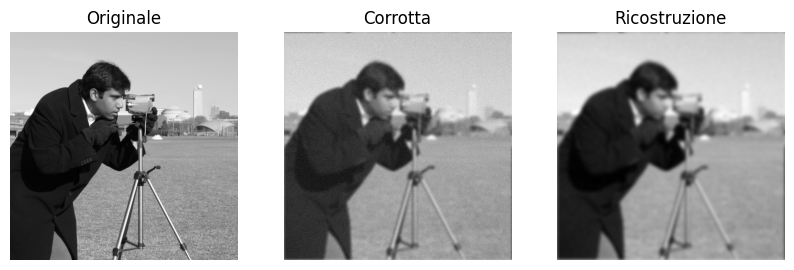

ER 0.12106248980390448
PSNR 23.030574771839003
SSIM 0.6514518805030891


In [9]:
# Calcolo soluzione regolarizzata con Total Variation 
#  problema di minimo risolto con Discesa Gradiente

# Solver per Total Variation
gd_tv_solver = solvers.GDTotalVariation(A, beta=1e-3)

# Scelta parametri TV (beta e lambda)
beta = 1e-3
lmbda = 1

# Scelta di x0, kmax, tolf, tolx
x0 = np.zeros_like(x)
kmax = 30
tolf = 1e-8
tolx = 1e-8

# Soluzione
x_TV, obj_val, grad_norm = gd_tv_solver.solve(y_delta, lmbda, x0, kmax, tolf, tolx)

# Visualizzazione ricostruzione
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(x, cmap="gray")
plt.title("Originale")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(y_delta, cmap="gray")
plt.axis("off")
plt.title("Corrotta")

plt.subplot(1, 3, 3)
plt.imshow(x_TV, cmap="gray")
plt.axis("off")
plt.title("Ricostruzione")
plt.show()

#Calcolo metriche di errore
print('ER',utilities.rel_err(x_TV,x))
print('PSNR',utilities.psnr(x_TV,x))
print('SSIM',utilities.ssim(x_TV,x))

- Il metodo di regolarizzazione con TV ha il vantaggio di essere particolarmente efficace
nell'eliminare il rumore e allo stesso tempo meglio preservare i
contorni, anche in caso di basso rapporto segnale/rumore.
- Il suo uso e' motivato dalla sua abilita' nel recuperare le
discontinuita' nell' immagine
- Preserva i bordi dell' immagine rimuovendo piccoli dettagli come il
rumore.
- All'aumentare del parametro di regolarizzazione l' immagine tende a
una immagine costante a tratti.